In [75]:
import numpy as np

import matplotlib.pyplot as plt
import copy
from public_tests import *
import tensorflow as tf 
import os as o
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2
np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
    return parameters

In [77]:
def initialize_parameters_deep(layers_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims)
    for l in range(1, L):
        parameters["W"+str(l)] = np.random.randn(layers_dims[l],
                                                 layers_dims[l-1])*0.01
        parameters['b'+str(l)] = np.zeros((layers_dims[l], 1))

        assert (parameters['W'+str(l)].shape ==
                (layers_dims[l], layers_dims[l-1]))
        assert (parameters['b'+str(l)].shape == (layers_dims[l], 1))

    return parameters

In [78]:
def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    cache = (A,W,b)
    return Z,cache

In [79]:
def relu(x):
    return x.clip(0)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z))
    return expZ / np.sum(expZ)

def linear_activation_forward(A_prev,W,b,activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = 1/(1+np.exp(-Z)),Z
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z),Z
        
    elif activation == 'softmax':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z),Z
        
    cache = (linear_cache, activation_cache)

    return A, cache

In [80]:
def L_model_forward(X,parameters):
    caches = []
    A= X
    L=len(parameters)//2
    for l in range(1,L):
        A_prev = A
        A,cache = linear_activation_forward(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],'relu')
        caches.append(cache)
    AL,cache = linear_activation_forward(A,parameters['W'+str(L)],parameters['b'+str(L)],'softmax')
    caches.append(cache)

    return AL,caches

In [81]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -np.sum(Y * np.log(AL)) / m
    # cost = -1 / m * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    cost = np.squeeze(cost)
    return cost

In [82]:
def linear_backward(dZ,cache):
    A_prev,W,b = cache
    m=A_prev.shape[1]
    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=1)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev,dW,db

In [83]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def softmax_backward(dA,activation_cache):
    expZ =dA* np.exp(activation_cache - np.max(activation_cache))
    # expZ = expZ = np.exp(Z)
    Yi = expZ / np.sum(expZ)
    dz = Yi*(1-Yi)
    return dz

def sigmoid_backward(dA,activation_cache):
    dZ  =  dA * sigmoid(activation_cache)*(1-sigmoid(activation_cache))
    return dZ
    
def relu_backward(dA,activation_cache):
    dz =dA* np.where(activation_cache>0,1,0)
    return dz

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ =  relu_backward(dA,activation_cache)
        dA_prev, dW, db =  linear_backward(dZ,linear_cache)
        
    elif activation == "sigmoid":
        dZ =sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db =  linear_backward(dZ,linear_cache)

    elif activation =='softmax':
        dZ = softmax_backward(dA,activation_cache)
        dA_prev,dW,db = linear_backward(dZ,linear_cache)
        
    return dA_prev, dW, db

In [84]:
def L_model_backward(AL,Y,caches):
    grads = {}
    L = len(caches)
    # m = AL.shape[1]
    Y=Y.reshape(AL.shape)
    dAL = -(np.divide(Y,AL)-np.divide(1-Y,1-AL))
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp =linear_activation_backward(dAL,current_cache,'softmax')
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp , dW_temp,db_temp = linear_activation_backward(grads['dA'+str(l+1)],current_cache,'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] =dW_temp
        grads["db" + str(l + 1)] = db_temp
        
    return grads

In [85]:
def update_parameters(params, grads, learning_rate):
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*grads["dW" + str(l + 1)] 
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*grads["db" + str(l + 1)] 
    return parameters

In [86]:
o.listdir("../W4A2/Human_Emosion_Dataset")

['test', 'train']

In [87]:
train_dir = '../W4A2/Human_Emosion_Dataset/train'
test_dir = '../W4A2/Human_Emosion_Dataset/test'


In [88]:
train_data = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1.0/255.0,
    shear_range = 0.2,
    zoom_range=0.2,
    horizontal_flip =True
)
train_data

In [89]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0)

In [90]:
train_generator = train_data.flow_from_directory(
    train_dir,
    target_size=(64, 64),  
    batch_size=32, 
    class_mode='categorical' 
)

Found 231 images belonging to 3 classes.


In [91]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,  
    class_mode='categorical'
)

Found 183 images belonging to 3 classes.


In [92]:
import numpy as np

def extract_data(generator):
    images, labels = [], []
    for _ in range(len(generator)):
        image_batch, label_batch = next(generator)
        images.append(image_batch)
        labels.append(label_batch)
    images = np.concatenate(images)
    labels = np.concatenate(labels)
    return images, labels

# Reset generators to start from the beginning
train_generator.reset()
test_generator.reset()


# Extract images and labels
train_x_orig, train_y = extract_data(train_generator)

test_x_orig, test_y = extract_data(test_generator)

train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.

# Ensure train_y and test_y are shaped correctly
train_y = train_y.reshape(3, -1)
test_y = test_y.reshape(3, -1)

print("train_x's shape: " + str(train_x.shape))  # Should be (67500, 6719)
print("train_y's shape: " + str(train_y.shape))  # Should be (1, 6719)
print("test_x's shape: " + str(test_x.shape))    # Should be (67500, 2259)
print("test_y's shape: " + str(test_y.shape))

train_x's shape: (12288, 231)
train_y's shape: (3, 231)
test_x's shape: (12288, 183)
test_y's shape: (3, 183)


In [93]:
# i,d = next(train_generator)

In [94]:
# print(d[0])
# str(np.argmax(d[0]))

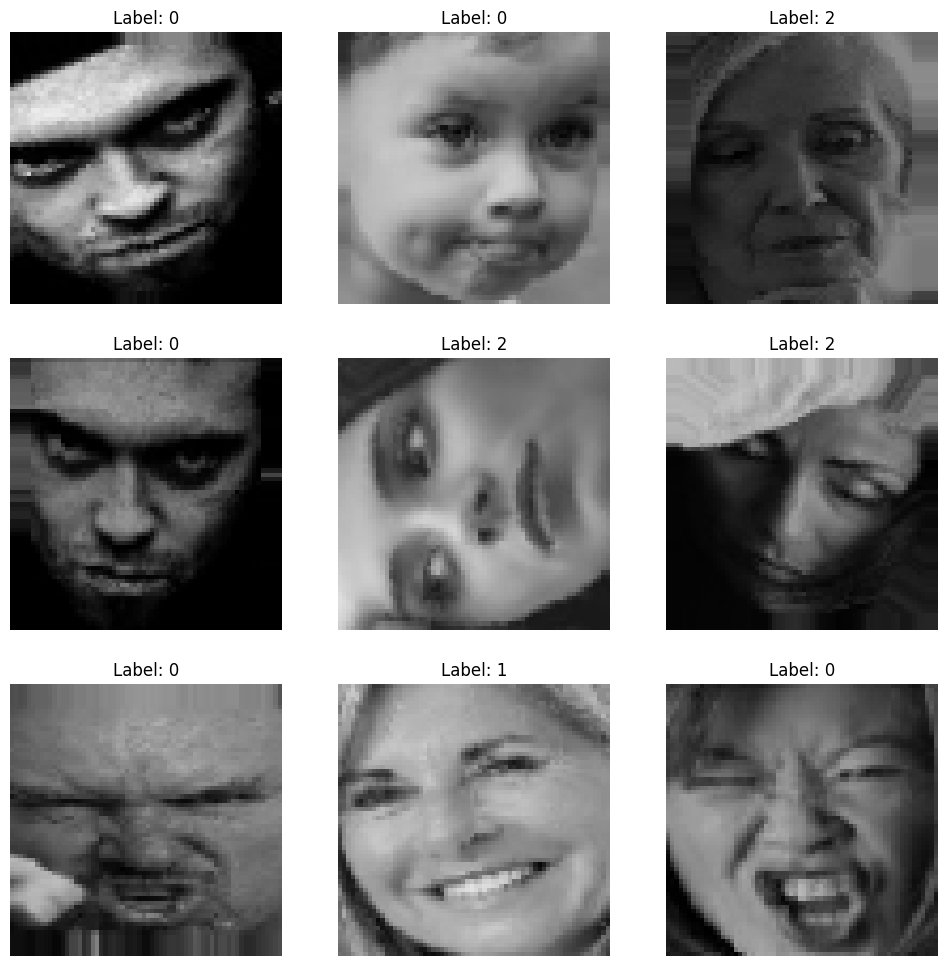

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels
images, labels = next(train_generator)

# Plot the images
plt.figure(figsize=(12, 12))
for i in range(9):  # Plot the first 9 images
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title('Label: ' + str(np.argmax(labels[i])))
    plt.axis('off')
plt.show()

In [96]:
# category_mapping = {0: "happy", 1: "sad", 2: "angry"}
# def decode_labels(one_hot_labels):
#     numerical_labels = np.argmax(one_hot_labels, axis=1)
#     category_labels = [category_mapping[label] for label in numerical_labels]
#     return category_labels

# # Decode train and test labels
# train_y_decoded = decode_labels(train_y)
# test_y_decoded = decode_labels(test_y)
# print(train_y_decoded)

In [97]:
train_y = train_y.reshape(3, -1)[:, :train_x.shape[1]]
test_y = test_y.reshape(3, -1)[:, :test_x.shape[1]]
print("train_x's shape: " + str(train_x.shape))
print("train_y's shape: " + str(train_y.shape))  
print("test_x's shape: " + str(test_x.shape))    
print("test_y's shape: " + str(test_y.shape))

train_x's shape: (12288, 231)
train_y's shape: (3, 231)
test_x's shape: (12288, 183)
test_y's shape: (3, 183)


In [98]:
n_x = 12288 
n_h = 7
n_y = 3
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [99]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 500, print_cost=False):
    np.random.seed(3)
    costs = []                         
    parameters = initialize_parameters_deep(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X,parameters)
        cost = compute_cost(AL,Y)
        grads = L_model_backward(AL,Y,caches)
        
        parameters = update_parameters(parameters,grads,learning_rate)
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return parameters, costs

In [100]:
import pandas as pd 
parameters = initialize_parameters_deep(layers_dims)
AL, caches = L_model_forward(train_x, parameters)
pd.DataFrame(AL[:, 0:5])

,0,1,2,3,4
0,0.001443,0.001443,0.001443,0.001443,0.001443
1,0.001443,0.001443,0.001443,0.001443,0.001443
2,0.001443,0.001443,0.001443,0.001443,0.001443


Cost after iteration 0: 6.541030473678796


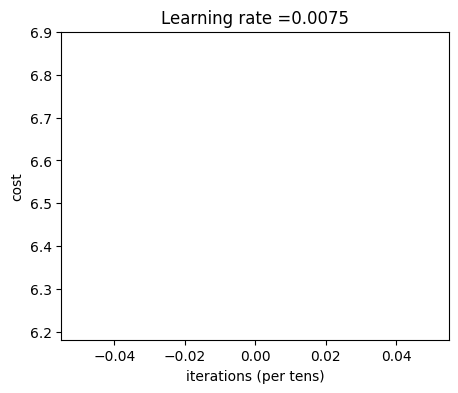

Cost after first iteration: 6.541030473678796


In [101]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 1, print_cost = False)

print("Cost after first iteration: " + str(costs[0]))


Cost after iteration 0: 6.541030473678796
Cost after iteration 100: 6.541030478446328
Cost after iteration 199: 6.5410304818554925


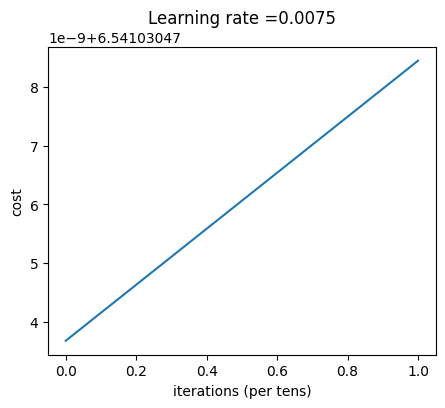

In [102]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 200, print_cost = True)

Cost after iteration 0: 6.541030473678796
Cost after iteration 1: 6.5410304736863685


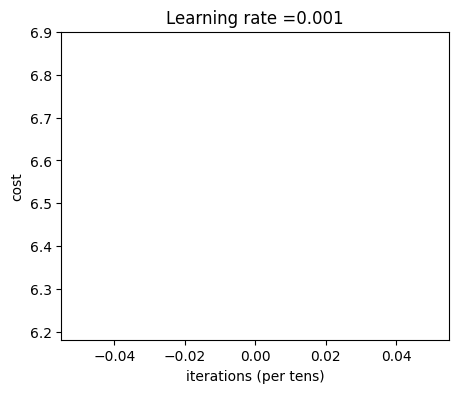

In [103]:
def predict(X, parameters):
    # Forward propagation
    probabilities, caches = L_model_forward(X, parameters)
    
    # Calculate Predictions (the highest probability for a given example is coded as 1, otherwise 0)
    predictions = (probabilities == np.amax(probabilities, axis=0, keepdims=True))
    predictions = predictions.astype(float)

    return predictions, probabilities

def evaluate_prediction(predictions, Y):
    m = Y.shape[1]
    predictions_class = predictions.argmax(axis=0).reshape(1, m)
    Y_class = Y.argmax(axis=0).reshape(1, m)
    
    return np.sum((predictions_class == Y_class) / (m))


parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.001, num_iterations = 2, print_cost=True)

In [104]:
def predict2(X, y, parameters):
    print("X=", X)
    print(X.shape)
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1, m))

    # Forward propagation
    probas, caches = L_model_forward(X, parameters)
    print("probas", probas)

    # Select the class with the highest probability
    predictions = np.argmax(probas, axis=0)
    accuracy = np.mean(predictions == np.argmax(y, axis=0))
    print("Accuracy: " + str(accuracy))
    return predictions

Cost after iteration 0: 6.541030473678796
Cost after iteration 2: 6.541030473792377


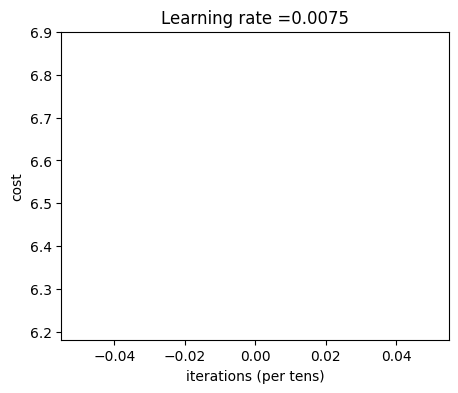

X= [[0.00059314 0.00156863 0.00098837 ... 0.00358245 0.00036768 0.00199923]
 [0.00059314 0.00156863 0.00098837 ... 0.00358245 0.00036768 0.00199923]
 [0.00059314 0.00156863 0.00098837 ... 0.00358245 0.00036768 0.00199923]
 ...
 [0.00022569 0.00286044 0.00375966 ... 0.00345022 0.00015745 0.00289222]
 [0.00022569 0.00286044 0.00375966 ... 0.00345022 0.00015745 0.00289222]
 [0.00022569 0.00286044 0.00375966 ... 0.00345022 0.00015745 0.00289222]]
(12288, 231)
probas [[0.00144299 0.00144295 0.00144297 0.001443   0.00144297 0.00144296
  0.001443   0.00144295 0.00144296 0.00144295 0.00144296 0.00144298
  0.00144295 0.00144297 0.00144293 0.00144298 0.00144296 0.00144294
  0.00144298 0.00144296 0.00144295 0.00144297 0.00144297 0.00144296
  0.00144297 0.00144297 0.00144299 0.00144295 0.00144296 0.00144297
  0.00144296 0.00144299 0.00144298 0.00144298 0.00144294 0.00144296
  0.00144292 0.00144293 0.00144296 0.00144296 0.00144297 0.00144297
  0.00144296 0.00144298 0.00144298 0.00144298 0.00144298 

In [105]:
from sklearn.preprocessing import OneHotEncoder

parameters, costs = L_layer_model(
    train_x, train_y, layers_dims, num_iterations=3, print_cost=True)


train_predictions = predict2(train_x, train_y, parameters)


test_predictions = predict2(test_x, test_y, parameters)


print("Train Accuracy: " +
      str(np.mean(train_predictions == np.argmax(train_y, axis=0))))
print("Test Accuracy: " + str(np.mean(test_predictions == np.argmax(test_y, axis=0))))

Cost after iteration 0: 6.541030473678796
Cost after iteration 99: 6.541030474406496


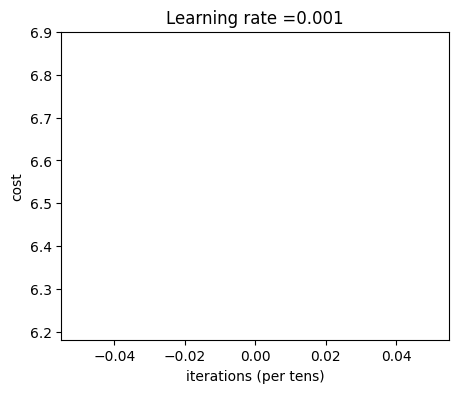

In [106]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.001, num_iterations = 100, print_cost=True)

In [107]:
print(parameters)

({'W1': array([[ 0.01788628,  0.0043651 ,  0.00096497, ...,  0.00742033,
         0.00777721, -0.02044101],
       [-0.02034741, -0.01277108, -0.00845047, ..., -0.01592858,
         0.01189758,  0.0136909 ],
       [ 0.00736324,  0.01040033, -0.00610758, ..., -0.00719971,
         0.01342522, -0.00194119],
       ...,
       [-0.00376099,  0.0047808 ,  0.01337956, ...,  0.00258237,
         0.00470035, -0.0088996 ],
       [ 0.02287234, -0.01013267,  0.00166334, ...,  0.0135046 ,
         0.01122616, -0.01048173],
       [ 0.00369967, -0.00146788,  0.00990617, ..., -0.00549949,
        -0.00973773, -0.00078118]]), 'b1': array([[ 0.00000000e+00],
       [-6.69322812e-08],
       [ 2.75012241e-06],
       [ 9.86330945e-08],
       [-1.97567614e-07],
       [ 8.40909967e-07],
       [-3.36371768e-07]]), 'W2': array([[ 0.0003273 ,  0.0039463 , -0.01763728, -0.01225447, -0.00218918,
        -0.00223227,  0.00571411],
       [ 0.00419842,  0.00037973, -0.01140611,  0.01491397, -0.00323294,
 

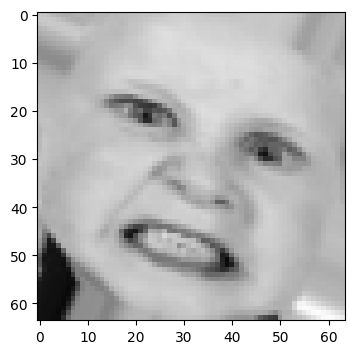

predict= [[0.]
 [1.]
 [0.]]
1
T= [[0.32910301]
 [0.33847601]
 [0.33242098]]


In [108]:
from PIL import Image
import matplotlib.pyplot as plt
num_px = 64
imageP = "images/12143.jpg"
image = np.array(Image.open(imageP).resize((num_px, num_px)))
plt.imshow(image)
plt.show()
parameter2s = initialize_parameters_deep(layers_dims)
image = image / 255.0  # Normalize image

image = image.reshape((1, num_px * num_px * 3)).T

prediction ,t = predict(image,parameter2s)
print('predict=',prediction)
print(np.argmax(prediction))
# print(np.argmax(predict))
print("T=",t)

In [109]:
print(train_y)

[[0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
  0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.
  0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
  0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.
  1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.
  1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
  0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
  0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
  0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
  0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
  1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.
  0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.

In [110]:
import numpy as np

# Example output from the model
prediction = (np.array([[1.], [0.], [0.]]), np.array([[0.6], [0.2], [0.2]]))

# Extract the probability distribution
probabilities = prediction[1]

# Get the index of the highest probability
predicted_class_index = np.argmax(probabilities)

# Define the class labels
class_labels = ["happy", "sad", "angry"]

# Map the predicted index to the corresponding class label
predicted_class_label = class_labels[predicted_class_index]

# Print the results
print("Predicted class index:", predicted_class_index)
print("Predicted class label:", predicted_class_label)
print("Class probabilities:", probabilities.flatten())


Predicted class index: 0
Predicted class label: happy
Class probabilities: [0.6 0.2 0.2]


(231, 64, 64, 3)
(224, 224, 3)


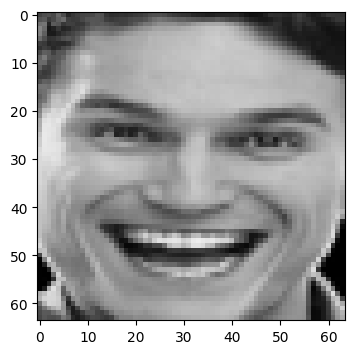

TypeError: tuple indices must be integers or slices, not str

In [111]:
from PIL import Image
my_image = "hap.jpg"  # Change this to the name of your image file
my_label_y = [1]
num_px = train_x_orig.shape[1]
print(train_x_orig.shape)
# Load, resize, and normalize the image
fname = "images/" + my_image
ii = np.array(Image.open(fname))
print(ii.shape)
image = np.array(Image.open(fname).resize((num_px, num_px)))

plt.imshow(image)
plt.show()

image = image / 255.  # Normalize image
image = image.reshape((1, num_px * num_px*3)).T  # Flatten and reshape
probas, _ = L_model_forward(image, parameters)
prediction = np.argmax(probas, axis=0)

# Assuming 'parameters' is already defined and trained
prediction = predict_image(fname, parameters)
print(prediction)
# Print the prediction
print(str(np.squeeze(prediction)))
# print("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" +
#       ("happy" if np.squeeze(my_predicted_image) == 1 else "not happy") + "\" picture.")